In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython import display

## 生成数据集
---

In [20]:
n_train = 50                                    ## 训练样本数
x_train, _ = torch.sort(torch.rand(n_train)*5)  ## 排序后的训练样本
f = lambda x: 2*torch.sin(x) + x**0.8
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)                ## 测试样本
y_test = f(x_test)                              ## 测试样本的真实输出
n_test = len(x_test)                            ## 测试样本数
n_test

50

In [21]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, xlim, ylim):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.grid()

def plot(xs, ys, xlabel, ylabel, xlim=None, ylim=None, xscale='linear', yscale='linear', legend=None, figsize=(6, 3)):
    plt.rcParams['figure.figsize'] =figsize
    set_axes(plt.gca(), xlabel, ylabel, xscale, yscale, xlim, ylim)
    try:
        len(xs[0])
    except:
        xs = [xs]
    for x, y in zip(xs, ys):
        plt.plot(x, y)
    plt.legend(legend if legend else [])

def plot_kernel_reg(y_hat):
    plot([x_test, x_test], [y_test, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    plt.plot(x_train, y_train, 'o', alpha=0.5)

## 平均汇聚
---

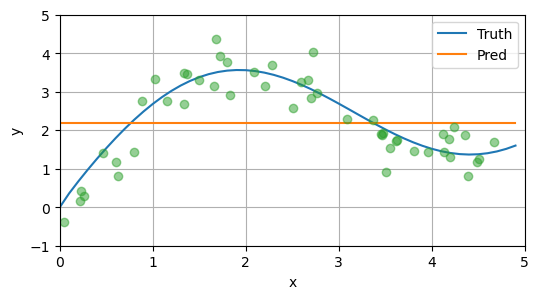

In [22]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [23]:
"""example
a = torch.tensor([1, 2, 3])
b = a.repeat_interleave(5)
b
"""
"""output
tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])
"""

'output\ntensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])\n'

## 非参数注意力汇聚
---

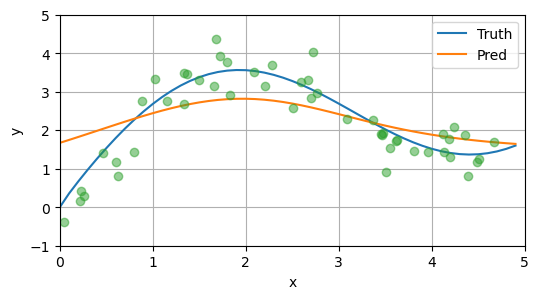

In [24]:
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
attention_weights = F.softmax(-(x_repeat - x_train)**2/2, dim=1)  
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [25]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows-1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

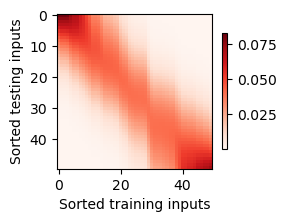

In [26]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## 带参数注意力汇聚
---

In [27]:
"""example
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
print(torch.bmm(X, Y) )
print(torch.matmul(X, Y))
"""
"""output
tensor([[[4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.]]])
tensor([[[4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.]]])
"""

'output\ntensor([[[4., 4., 4., 4., 4., 4.]],\n\n        [[4., 4., 4., 4., 4., 4.]]])\ntensor([[[4., 4., 4., 4., 4., 4.]],\n\n        [[4., 4., 4., 4., 4., 4.]]])\n'

In [28]:
## 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super(NWKernelRegression, self).__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    def forward(self, queries, keys, values):
        ## query和attention_weights的形状为(查询个数, 键值对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = F.softmax(
            -((queries-keys)*self.w)**2/2, dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [29]:
"""example
a = torch.tensor([[1,2,3],[4,5,6]])
a.unsqueeze(1), a.unsqueeze(-1), a.unsqueeze(1).shape, a.unsqueeze(-1).shape
"""
"""output
(tensor([[[1, 2, 3]],
 
         [[4, 5, 6]]]),
 tensor([[[1],
          [2],
          [3]],
 
         [[4],
          [5],
          [6]]]),
 torch.Size([2, 1, 3]),
 torch.Size([2, 3, 1]))
"""

'output\n(tensor([[[1, 2, 3]],\n \n         [[4, 5, 6]]]),\n tensor([[[1],\n          [2],\n          [3]],\n \n         [[4],\n          [5],\n          [6]]]),\n torch.Size([2, 1, 3]),\n torch.Size([2, 3, 1]))\n'

In [30]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

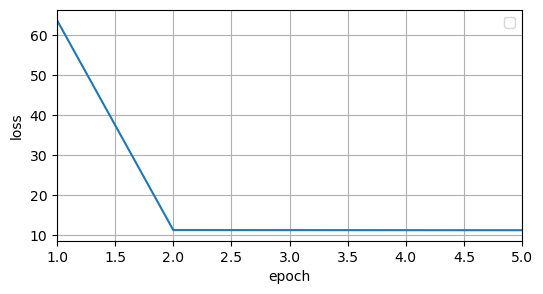

In [31]:
## 训练
x_tile = x_train.repeat((n_train, 1))
y_tile = y_train.repeat((n_train, 1))
keys = x_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1,5])
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1}, loss {float(l.sum()):.6f}')
    animator.add(epoch+1, float(l.sum()))

In [32]:
"""example
x = torch.tensor([1,2,3])
x.repeat((5,)), x.repeat((5,2))
"""
"""output
(tensor([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]),
 tensor([[1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3]]))
"""

'output\n(tensor([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]),\n tensor([[1, 2, 3, 1, 2, 3],\n         [1, 2, 3, 1, 2, 3],\n         [1, 2, 3, 1, 2, 3],\n         [1, 2, 3, 1, 2, 3],\n         [1, 2, 3, 1, 2, 3]]))\n'

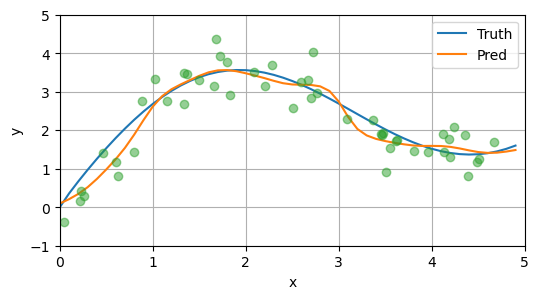

In [33]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).detach()
plot_kernel_reg(y_hat)

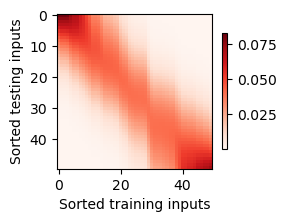

In [36]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## Exercises
---

1. 增加训练数据的样本数量，能否得到更好的非参数的Nadaraya-Watson核回归模型？

2. 在带参数的注意力汇聚的实验中学习得到的参数$w$的价值是什么？为什么在可视化注意力权重时，它会使加权区域更加尖锐?

3. 如何将超参数添加到非参数的Nadaraya-Watson核回归中以实现更好地预测结果？

4. 为本节的核回归设计一个新的带参数的注意力汇聚模型。训练这个新模型并可视化其注意力权重